# 프로젝트 - movielens 영화 추천 실습
- MF 모델학습방법으로 좋아할 만한 영화 추천 시스템을 제작


- 별점데이터는 explicit데이터이지만, implicit데이터로 간주하고 테스트
- 별점을 시청횟수로 해석해서 생각
- 3점 미만으로 준 데이터는 선호하지 않는다고 가정하고 제외

# 목표
- 추천시스템 개념과 목적
- implicit 라이브러리를 활용하여 matrix factorization(MF)기반의 추천 모델
- 별점을 활용하여 비슷한 영화를 찾고 영화 추천
- 추천 시스템에서 자주 사용되는 데이터 구조인 CSR Matrix
- Explicit data와 implicit data의 차이점을 익힌다
- 새로운 데이터셋으로 직접 추천 모델을 만든다.

# 데이터 준비 및 전처리

In [1]:
import os
import pandas as pd

rating_file_path = os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'ratings', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)
ratings.head()

,user_id,movie_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [2]:
# 3점 이상만 남깁니다.
ratings = ratings[ratings['ratings']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [3]:
# ratings 컬럼의 이름을 counts로 바꿉니다.
ratings.rename(columns={'ratings':'counts'}, inplace=True)

In [4]:
ratings

,user_id,movie_id,counts,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000203,6040,1090,3,956715518
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [5]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
# data확인을 쉽게 하기 위한 merge
data = pd.merge(ratings,movies,on='movie_id')
data.sort_values(ascending=True,by='movie_id')

,user_id,movie_id,counts,timestamp,title,genre
39573,2989,1,5,970774804,Toy Story (1995),Animation|Children's|Comedy
39611,3095,1,5,969652850,Toy Story (1995),Animation|Children's|Comedy
39610,3090,1,4,969660551,Toy Story (1995),Animation|Children's|Comedy
39609,3087,1,5,969738110,Toy Story (1995),Animation|Children's|Comedy
39608,3081,1,5,969801904,Toy Story (1995),Animation|Children's|Comedy
...,...,...,...,...,...,...
604919,627,3952,4,975783105,"Contender, The (2000)",Drama|Thriller
604918,623,3952,4,975793580,"Contender, The (2000)",Drama|Thriller
604917,611,3952,3,977425911,"Contender, The (2000)",Drama|Thriller
604940,838,3952,5,975359004,"Contender, The (2000)",Drama|Thriller


### 분석
- ratings에 있는 유니크한 영화 개수
- ratings에 있는 유니크한 사용자 수
- 가장 인기 있는 영화 30개(인기순)

In [7]:
# ratings에 있는 유니크한 영화 개수
data['movie_id'].nunique()

3628

In [8]:
# ratings에 있는 유니크한 사용자 수
data['user_id'].nunique()

6039

In [9]:
# 가장 인기 있는 영화30개(인기순)
movie_top30 = data.groupby('title')['counts'].count()
movie_top30.sort_values(ascending=False).head(30)

title
American Beauty (1999)                                   3211
Star Wars: Episode IV - A New Hope (1977)                2910
Star Wars: Episode V - The Empire Strikes Back (1980)    2885
Star Wars: Episode VI - Return of the Jedi (1983)        2716
Saving Private Ryan (1998)                               2561
Terminator 2: Judgment Day (1991)                        2509
Silence of the Lambs, The (1991)                         2498
Raiders of the Lost Ark (1981)                           2473
Back to the Future (1985)                                2460
Matrix, The (1999)                                       2434
Jurassic Park (1993)                                     2413
Sixth Sense, The (1999)                                  2385
Fargo (1996)                                             2371
Braveheart (1995)                                        2314
Men in Black (1997)                                      2297
Schindler's List (1993)                                  2257
Pr

### 내가 선호하는 영화를 5가지 골라서 rating에 추가

In [10]:
favorite_movie = ['Jurassic Park (1993)', 'Men in Black (1997)','Godfather, The (1972)','Forrest Gump (1994)','Toy Story (1995)']
# 5가지 영화를 각각 5번식 봤다는 가정하
my_movie = pd.DataFrame({'user_id':['yong']*5, 'title':favorite_movie, 'counts':[5]*5})
if not data.isin({'user_id':['yong']})['user_id'].any():
    data = data.append(my_movie)
data.tail(10)

,user_id,movie_id,counts,timestamp,title,genre
836473,5851,3607.0,5,9.577566e+08,One Little Indian (1973),Comedy|Drama|Western
836474,5854,3026.0,4,9.583469e+08,Slaughterhouse (1987),Horror
836475,5854,690.0,3,9.577443e+08,"Promise, The (Versprechen, Das) (1994)",Romance
836476,5938,2909.0,4,9.572734e+08,"Five Wives, Three Secretaries and Me (1998)",Documentary
836477,5948,1360.0,5,1.016564e+09,Identification of a Woman (Identificazione di ...,Drama
0,yong,NaN,5,NaN,Jurassic Park (1993),NaN
1,yong,NaN,5,NaN,Men in Black (1997),NaN
2,yong,NaN,5,NaN,"Godfather, The (1972)",NaN
3,yong,NaN,5,NaN,Forrest Gump (1994),NaN
4,yong,NaN,5,NaN,Toy Story (1995),NaN


# 데이터 전처리

In [11]:
user_unique = data['user_id'].unique()
movie_unique = data['title'].unique()

user_to_index = {v:k for k,v in enumerate(user_unique)}
movie_to_index = {v:k for k,v in enumerate(movie_unique)}

In [12]:
print(user_to_index['yong'])
print(movie_to_index['Jurassic Park (1993)'])

6039
107


In [13]:
# user_to_index 결측치제거
temp_user_data = data['user_id'].map(user_to_index.get).dropna()
if len(temp_user_data) == len(data):   # 모든 row가 정상적으로 인덱싱되었다면
    data['user_id'] = temp_user_data   # data['user_id']을 인덱싱된 Series로 교체 
    
# movie_to_index 결측치제거
temp_movie_data = data['title'].map(movie_to_index).dropna()
if len(temp_movie_data)==len(data):
    data['title'] = temp_movie_data
data    

,user_id,movie_id,counts,timestamp,title,genre
0,0,1193.0,5,978300760.0,0,Drama
1,1,1193.0,5,978298413.0,0,Drama
2,2,1193.0,4,978220179.0,0,Drama
3,3,1193.0,4,978199279.0,0,Drama
4,4,1193.0,5,978158471.0,0,Drama
...,...,...,...,...,...,...
0,6039,NaN,5,NaN,107,NaN
1,6039,NaN,5,NaN,175,NaN
2,6039,NaN,5,NaN,607,NaN
3,6039,NaN,5,NaN,160,NaN


# CSR(Compressed Sparse Row) Matrix

- 거대한 행렬을 조그마한 메모리에 올려놓는것은 불가능하므로 CSR을 사용한다.
- Sparse한 matrix에서 0이 아닌 데이터로 채워지는 데이터의 값과 좌표 정보만으로 구성하여 메모리 사용량을 최소화하고 전체데이터와 동일한 행렬을 표현할 수 있도록 하는 데이터 구조

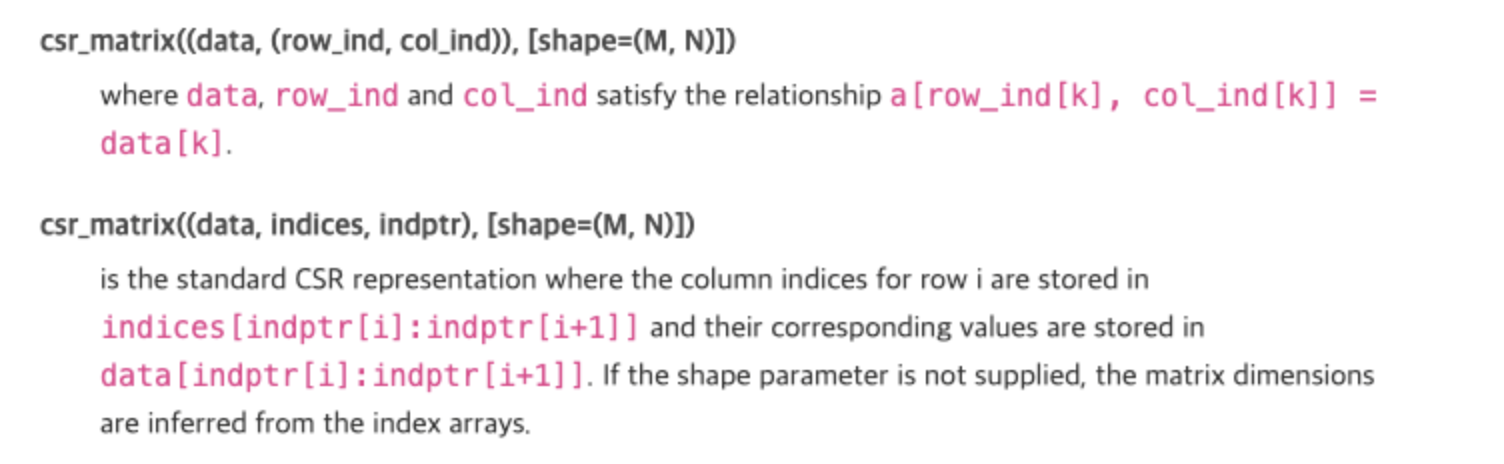

In [14]:
from scipy.sparse import csr_matrix
num_user = data['user_id'].nunique()
num_movie = data['title'].nunique()

csr_data = csr_matrix((data.counts, (data.user_id, data.title)), shape=(num_user, num_movie))
csr_data

<6040x3628 sparse matrix of type '<class 'numpy.longlong'>'
	with 836483 stored elements in Compressed Sparse Row format>

# MF 모델 학습
### implicit패키지활용
- implicit 패키지는 암묵적 데이터셋을 사용하는 모델을 빠르게 학습할 수 있는 패키지
- ```als```모델을 사용

In [15]:
from implicit.als import AlternatingLeastSquares
import os
import numpy as np

os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

### AlternatingLeastSquares
- 1. factors : 유저와 아이템의 벡터를 몇 차원으로
- 2. regularization : 과적합 방지를 위해 정규화 값을 얼마나 사용하는지
- 3. use_gpu : GPU사용하는지
- 4. iterations: epochs

In [16]:
# 모델선언
als_model = AlternatingLeastSquares(factors=100, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)

In [17]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose

<3628x6040 sparse matrix of type '<class 'numpy.longlong'>'
	with 836483 stored elements in Compressed Sparse Column format>

In [18]:
# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

# 내가 선호하는 5가지 영화 중 하나와 그 외의 영화 하나를 골라 훈련된 모델이 예측한 나의 선호도

### 그 외의 영화와 나의 선호도

In [19]:
yong, Indian = user_to_index['yong'], movie_to_index['One Little Indian (1973)']
yong_vector, Indian_vector = als_model.user_factors[yong], als_model.item_factors[Indian]

In [20]:
yong_vector

array([ 0.22480214,  0.46160257, -1.5183598 ,  0.5244934 ,  0.58305156,
        0.3409357 ,  0.23725523, -0.5023298 ,  0.9694103 ,  1.0524305 ,
       -0.15059507,  0.17978556, -1.0732318 , -0.62058187, -0.05293965,
        0.37705043,  0.21360855,  0.09299643,  0.00624382, -0.10069047,
        0.07411563,  0.4777262 ,  0.03521577, -0.2979376 ,  0.74803895,
       -0.05442818,  0.5421131 , -1.1894071 ,  0.21960819, -0.4964615 ,
        0.73315805,  0.4952786 ,  0.50747424, -0.25467047, -0.70704603,
        0.57015747,  0.04910159,  0.3583828 ,  0.8278703 ,  0.18841451,
        0.19186734, -0.4875311 ,  0.33107552,  1.0405138 ,  0.07969545,
        0.21790336,  0.15576404, -0.00195286, -0.28319672, -0.45151365,
       -0.8670765 , -0.3109057 ,  0.82483655, -0.04743959,  0.39143437,
       -0.16412537, -0.3744717 ,  0.8098111 ,  0.22401369, -0.6285746 ,
       -0.3429966 ,  0.22838785,  0.85356855,  0.4307062 , -0.31661358,
       -0.20018607,  0.78848827, -1.0508825 ,  1.0604873 , -0.98

In [21]:
Indian_vector

array([ 8.4572070e-04,  7.3623814e-05, -5.6321762e-04, -3.8367999e-04,
       -4.3301781e-05,  6.1073725e-04,  3.4915932e-04,  4.2500040e-05,
       -3.8029434e-04,  4.8469278e-04, -2.2637675e-04,  1.1148034e-03,
        5.3363439e-04,  1.1390154e-03,  1.7159331e-03,  1.8283495e-03,
        1.6606468e-03, -7.3358370e-04, -9.8401033e-05, -1.7152207e-04,
        4.8544758e-04,  2.0828313e-04,  8.8600314e-04,  7.2142255e-04,
        1.2187596e-03,  3.4213596e-04,  1.6574452e-03,  2.3899073e-04,
        3.4461415e-04,  7.5548881e-04,  5.9417065e-04,  9.2250382e-04,
        4.4733417e-04,  7.2180334e-04,  5.3428323e-04, -1.9883005e-04,
        1.3444970e-03,  1.4440514e-03, -1.3487395e-04, -5.9660965e-06,
        1.1754107e-03,  5.4511125e-04,  1.6518114e-03, -3.7775416e-04,
        4.8212142e-04, -7.4913353e-04, -3.0555355e-04, -4.9364398e-04,
        9.0339727e-04,  3.3535593e-04,  7.6079776e-04,  4.2341743e-04,
       -1.1845108e-04, -2.3783695e-04, -1.1408228e-04,  1.0523440e-03,
      

In [22]:
np.dot(yong_vector, Indian_vector)

0.002014799

### 내가 고른 영화와 나의 선호도

In [23]:
jurassic = movie_to_index['Jurassic Park (1993)']
jurassic_vector = als_model.item_factors[jurassic]
np.dot(yong_vector, jurassic_vector)

0.67261416

# 내가 좋아하는 영화와 비슷한 영화

In [24]:
movie_id = movie_to_index['Jurassic Park (1993)']
similar_movie = als_model.similar_items(movie_id, N=30)
similar_movie

[(107, 1.0),
 (175, 0.8255095),
 (92, 0.71937954),
 (62, 0.5969508),
 (124, 0.53946376),
 (82, 0.48453748),
 (3466, 0.46653304),
 (87, 0.4522043),
 (150, 0.40277708),
 (1754, 0.3896452),
 (58, 0.38415742),
 (179, 0.3817064),
 (542, 0.37818334),
 (3136, 0.3728589),
 (375, 0.3666158),
 (3482, 0.3608634),
 (145, 0.35835987),
 (1122, 0.35264945),
 (3512, 0.35231575),
 (3100, 0.35159916),
 (3141, 0.35061878),
 (3081, 0.35053456),
 (3272, 0.34980598),
 (3481, 0.34953082),
 (913, 0.34851414),
 (3435, 0.3473761),
 (3263, 0.34568083),
 (1713, 0.3413551),
 (1930, 0.33880967),
 (2748, 0.33823875)]

In [25]:
# index --> title로 변환
idx_to_movie = {v:k for k,v in movie_to_index.items()}
[idx_to_movie[i[0]] for i in similar_movie]

['Jurassic Park (1993)',
 'Men in Black (1997)',
 'Terminator 2: Judgment Day (1991)',
 'Total Recall (1990)',
 'Matrix, The (1999)',
 'Lost World: Jurassic Park, The (1997)',
 'Schlafes Bruder (Brother of Sleep) (1995)',
 'Braveheart (1995)',
 'Independence Day (ID4) (1996)',
 'Little Odessa (1994)',
 'Mission: Impossible (1996)',
 'Rock, The (1996)',
 'Rocky Horror Picture Show, The (1975)',
 'Man of No Importance, A (1994)',
 'Face/Off (1997)',
 "Pot O' Gold (1941)",
 'Fifth Element, The (1997)',
 'Repo Man (1984)',
 'City of the Living Dead (Paura nella città dei morti viventi) (1980)',
 'Little City (1998)',
 'Maybe, Maybe Not (Bewegte Mann, Der) (1994)',
 'Bedrooms & Hallways (1998)',
 'Plenty (1985)',
 'Man from Down Under, The (1943)',
 'Fly, The (1986)',
 'Woman of Paris, A (1923)',
 'End of the Affair, The (1955)',
 'Mother Night (1996)',
 'Bank Dick, The (1940)',
 'Bewegte Mann, Der (1994)']

# 내가 좋아할만한 영화 추천
- ``` AlternatingLeastSquares``` 클래스의 ```recommend``` 메소드를 통하여 아티스트 추천
- ``` filter_already_liked_items``` 는 유저가 이미 평가한 아이템은 제외

In [26]:
user = user_to_index['yong']

movie_recommended = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=True)
movie_recommended

[(380, 0.5499301),
 (50, 0.4875586),
 (92, 0.4210134),
 (64, 0.35596204),
 (435, 0.33011264),
 (110, 0.30976373),
 (124, 0.29830334),
 (87, 0.29037082),
 (4, 0.28261966),
 (99, 0.26020402),
 (150, 0.2568618),
 (322, 0.25397065),
 (60, 0.24651954),
 (62, 0.243576),
 (44, 0.22999674),
 (48, 0.21631491),
 (33, 0.20830324),
 (117, 0.20520645),
 (141, 0.20276405),
 (475, 0.20223151)]

In [27]:
# 추천받은 영화들
[idx_to_movie[i[0]] for i in movie_recommended]

['Godfather: Part II, The (1974)',
 'Toy Story 2 (1999)',
 'Terminator 2: Judgment Day (1991)',
 'Star Wars: Episode VI - Return of the Jedi (1983)',
 'Godfather: Part III, The (1990)',
 'Groundhog Day (1993)',
 'Matrix, The (1999)',
 'Braveheart (1995)',
 "Bug's Life, A (1998)",
 'American Beauty (1999)',
 'Independence Day (ID4) (1996)',
 'Babe (1995)',
 'Star Wars: Episode I - The Phantom Menace (1999)',
 'Total Recall (1990)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'Saving Private Ryan (1998)',
 'Aladdin (1992)',
 'Star Wars: Episode V - The Empire Strikes Back (1980)',
 'Fugitive, The (1993)',
 'My Cousin Vinny (1992)']

# 추천기여도

In [28]:
father = movie_to_index['Godfather: Part II, The (1974)']
explain = als_model.explain(user, csr_data, itemid=father)
[(idx_to_movie[i[0]], i[1]) for i in explain[1]]

[('Godfather, The (1972)', 0.568756497491809),
 ('Jurassic Park (1993)', 0.005509566520927575),
 ('Toy Story (1995)', -0.005393772265000334),
 ('Forrest Gump (1994)', -0.012884542473940469),
 ('Men in Black (1997)', -0.015236960410370762)]

### 고찰
- 마지막의 추천 기여도는 Godfather 1 시리즈의 영향을 가장 많이 받은걸로 나온 것으로 보아 기여도 추천이 어느정도 잘됐다고 생각.